## 1. Business Understanding

### Project Background
Film production is a high-risk, capital-intensive industry. For a new movie studio, selecting projects with strong financial performance is essential to minimizing risk and ensuring sustainable growth.

### Real-World Problem
The studio needs to decide which films to produce by identifying those with:
- High global gross profit and efficient budget utilization (high ROI).
- Favorable trends in market performance over time.
- Successful genres and proven talent (directors and actors).

### Stakeholders
- **Studio Management & Investors:** Require data-driven recommendations to allocate resources effectively.
- **Production Teams:** Benefit by focusing on film attributes that historically correlate with success.

This analysis provides a clear roadmap, enabling stakeholders to make informed decisions that address a real-world business challenge.


## 2. Data Understanding

### Data Sources
1. **Movie Budgets Data:**  
   - Contains production budgets, domestic and worldwide gross revenue, and release dates for films (post-2000).
   - Offers insights into financial performance.
   
2. **IMDb Data:**  
   - Provides film metadata including ratings, runtime, genres, and details about key personnel (actors, directors, etc.).
   - Comes from a SQLite database (and a supplemental CSV) that enriches our analysis.

### Data Properties and Relevance
- **Temporal Coverage:** Films released from 2000 onward.
- **Key Features:** Budget, revenues, profit, ROI, runtime, genres, cast/crew details.
- **Utility:** The financial data combined with IMDb metadata allows us to identify trends and evaluate the efficiency of budget usage across films.
- **Limitations:** Early encoding issues and missing values have been handled during data preparation to ensure data reliability.

Confirms that the data sources are well-suited to address the studio’s problem of identifying films with high potential.

## 3. Data Preparation

### Overview
In this section, we load, clean, and merge the raw datasets to create a master dataset for analysis. Steps include:
- Parsing dates and filtering films released from 2000 onward.
- Converting currency strings to floats.
- Fixing text encoding issues.
- Calculating Global Gross Profit and ROI.
- Merging budget data with enriched IMDb data via a composite key ("Title & Year").

In [42]:
# =============================================================================
# Environment Setup and Helper Functions (Code Quality: clear, commented, and DRY)
# =============================================================================
import os
import zipfile
import warnings
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Configure display options and suppress warnings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format
warnings.simplefilter('ignore')
sns.set_palette('viridis')
plt.style.use(['ggplot', 'dark_background'])

In [43]:
def fix_text_encoding(text):
    """Fix common text encoding issues in movie titles. Analysed the file to check for the encoding issue"""
    if isinstance(text, str):
        return text.replace('â\x80\x99', "'").replace('â\x80\x94', " ").replace('Ã©', "e")
    return text

def money_to_float(money_str):
    """Convert currency strings like '$1,234' into a float."""
    return float(money_str.replace('$', '').replace(',', ''))

In [ ]:
# =============================================================================
# Load and Clean Budget Data
# =============================================================================
df_budget = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz', 
                        parse_dates=['release_date'], encoding='utf-8')
df_budget.head(2)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [45]:
# Extract the release year and filter for movies from 2000 onward
df_budget['release_year'] = df_budget['release_date'].dt.year
df_budget = df_budget[df_budget['release_year'] >= 2000].copy()
df_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011


In [46]:
# Clean monetary columns by converting strings to floats
df_budget['production_budget'] = df_budget['production_budget'].apply(money_to_float)
df_budget['domestic_gross']   = df_budget['domestic_gross'].apply(money_to_float)
df_budget['worldwide_gross']  = df_budget['worldwide_gross'].apply(money_to_float)

In [47]:
# Calculate Global Gross Profit and Global Gross ROI
df_budget['Global_Gross_Profit'] = df_budget['worldwide_gross'] - df_budget['production_budget']
df_budget['Global_Gross_ROI']    = df_budget['Global_Gross_Profit'] / df_budget['production_budget']
df_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,Global_Gross_Profit,Global_Gross_ROI
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2


In [48]:
# Drop unnecessary columns and rename for clarity
df_budget.drop(columns=['id', 'release_date'], inplace=True)
rename_dict = {'movie': 'Title', 
               'production_budget': 'Budget', 
               'domestic_gross': 'Domestic_Gross_Rev', 
               'worldwide_gross': 'Global_Gross_Rev', 
               'release_year': 'Year'}
df_budget.rename(columns=rename_dict, inplace=True)
df_budget.head(10)


,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


In [49]:
# Fix text encoding issues in the Title column
df_budget['Title'] = df_budget['Title'].apply(fix_text_encoding)
df_budget.head(10)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI
0,Avatar,425000000,760507625,2776345279,2009,2351345279,6
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,2
2,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-1
3,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,3
5,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,1747311220,6
6,Avengers: Infinity War,300000000,678815482,2048134200,2018,1748134200,6
7,Pirates of the Caribbean: At World's End,300000000,309420425,963420425,2007,663420425,2
8,Justice League,300000000,229024295,655945209,2017,355945209,1
9,Spectre,300000000,200074175,879620923,2015,579620923,2


In [50]:
# Create composite key "Title & Year" for merging with IMDb data
df_budget['Title & Year'] = df_budget.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)


In [51]:
# Save target lists for filtering IMDb data
target_titles = df_budget['Title'].tolist()
target_title_years = df_budget['Title & Year'].tolist()

## Load IMDb Data from SQLite

The IMDb data provide additional film metadata including ratings, runtime, genres, and key personnel (actors, directors, etc.). We perform the following:
- Unzip and connect to the SQLite database.
- Execute an SQL query that joins multiple tables (film basics, ratings, and cast/crew information).
- Load a supplemental IMDb CSV file to enrich our data.
- Merge both sources using our composite key ("Title & Year") to ensure consistency with the budget data.


In [52]:
# Unzip the SQLite database if it doesn't exist
db_path = './zippedData/im.db'
if not os.path.exists(db_path):
    with zipfile.ZipFile('./zippedData/im.db.zip', 'r') as zf:
        zf.extractall('./zippedData')

In [62]:
# Connect to the SQLite database and execute the query
conn = sqlite3.connect('./zippedData/im.db')

In [63]:
sql_query = """
WITH big_table AS (
    SELECT 
        mb.movie_id,
        mb.primary_title,
        mb.start_year,
        mb.runtime_minutes,
        mb.genres,
        mr.averagerating,
        mr.numvotes
    FROM movie_basics AS mb
        JOIN movie_ratings AS mr USING(movie_id)
        JOIN principals AS pr USING(movie_id)
        JOIN persons AS ps USING(person_id)
    WHERE mb.start_year > 2000
    GROUP BY mb.movie_id
),
ActorNames AS (
    SELECT p.movie_id, GROUP_CONCAT(pe.primary_name) AS Actors
    FROM principals p JOIN persons pe USING(person_id)
    WHERE p.category IN ('actor', 'actress', 'self')
    GROUP BY p.movie_id
),
WriterNames AS (
    SELECT p.movie_id, GROUP_CONCAT(pe.primary_name) AS Writers
    FROM principals p JOIN persons pe USING(person_id)
    WHERE p.category IN ('writer')
    GROUP BY p.movie_id
),
DirectorNames AS (
    SELECT p.movie_id, GROUP_CONCAT(pe.primary_name) AS Directors
    FROM principals p JOIN persons pe USING(person_id)
    WHERE p.category IN ('director')
    GROUP BY p.movie_id
),
ProducerNames AS (
    SELECT p.movie_id, GROUP_CONCAT(pe.primary_name) AS Producers
    FROM principals p JOIN persons pe USING(person_id)
    WHERE p.category IN ('producer')
    GROUP BY p.movie_id
)
SELECT 
    b.movie_id AS ID,
    b.primary_title AS Title,
    b.start_year AS Year,
    b.runtime_minutes AS Runtime,
    b.genres AS Genres,
    b.averagerating AS AvgRating,
    b.numvotes AS VoteCount,
    a.Actors,
    w.Writers,
    d.Directors,
    p.Producers
FROM big_table b
    JOIN ActorNames a USING(movie_id)
    JOIN WriterNames w USING(movie_id)
    JOIN DirectorNames d USING(movie_id)
    JOIN ProducerNames p USING(movie_id)
ORDER BY b.primary_title;
"""

df_imdb_sql = pd.read_sql(sql_query, conn)
conn.close()
df_imdb_sql.head()

,ID,Title,Year,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,tt2346170,#1 Serial Killer,2013,87,Horror,6,40,"Jason Tobin,Eugenia Yuan,Tzi Ma,Shoshana Bush",Koji Steven Sakai,Stanley Yung,Quentin Lee
1,tt5255986,#66,2015,116,Action,5,18,"Ari Riski Ananda,Erwin Bagindo,Fandy Christian...",Matthew Ryan Fischer,Asun Mawardi,Gina Maria
2,tt5803530,#DigitalLivesMatter,2016,NaN,Comedy,6,19,"Rashan Ali,Carlos Aviles,Brooklyn Beedles,Ben ...",Cas Sigers-Beedles,Terri J. Vaughn,"Bobby Patterson,David Banner,D.C. Young Fly,An..."
3,tt5460468,#Enough,2015,NaN,Drama,2,7,"Mark Boyd,Jebediah Calhoun,Sean Davis,Adriane ...",Damion Stevenson,Miranda Ferguson,"John Boudreau,Joseph Calhoun"
4,tt5233106,#FollowFriday,2016,90,Thriller,3,186,"Courtney Lakin,Joseph Poliquin,Ashley Bratcher...","Marie Bertonneau,Anna Rasmussen",Micho Rutare,David Michael Latt


In [64]:
# Filter SQL IMDb data to keep only movies present in our budget dataset
df_imdb_sql = df_imdb_sql[df_imdb_sql['Title'].isin(target_titles)]
df_imdb_sql.shape

(1446, 11)

In [66]:
# Use the SQL IMDb data as the combined IMDb data
df_imdb_combined = df_imdb_sql.copy()
df_imdb_combined['Year'] = df_imdb_combined['Year'].astype(int)

# Create the composite key "Title & Year" in the IMDb dataframe
df_imdb_combined['Title & Year'] = df_imdb_combined.apply(lambda row: f"{row['Title']} - {row['Year']}", axis=1)


In [67]:
# Filter the IMDb combined data to include only movies in our target list (by composite key)
df_imdb_combined = df_imdb_combined[df_imdb_combined['Title & Year'].isin(target_title_years)]
df_imdb_combined.shape

(1039, 12)

## Merge Datasets and Finalize Master Data

Now we merge the cleaned budget data with the IMDb data based on the composite key. After merging:
- We save the master dataset to CSV (to ensure reproducibility) and reload it.
- We address any remaining issues with extra columns or runtime values.


In [68]:
# =============================================================================
# Merge Datasets and Finalize Master Data
# =============================================================================
df_master = pd.merge(df_budget, df_imdb_combined, on=['Title', 'Year', 'Title & Year'], how='inner')
df_master.head()
df_master.shape

(1039, 17)

In [69]:
# Save master data to CSV and then reload it for reproducibility
df_master.to_csv('./master_data.csv', index=False)
df = pd.read_csv('./master_data.csv')

In [71]:
# Remove extra columns if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
if 'Title & Year' in df.columns:
    df.drop(columns=['Title & Year'], inplace=True)

# Replace '\\N' in Runtime and convert to integer
df['Runtime'] = df['Runtime'].replace('\\N', '0').fillna('0').astype(float).astype(int)
df.head(3)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,3,tt2395427,141,"Action,Adventure,Sci-Fi",7,665594,"Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...","Stan Lee,Jack Kirby,Joe Simon,Jim Starlin",Joss Whedon,Kevin Feige
1,The Dark Knight Rises,275000000,448139099,1084439099,2012,809439099,3,tt1345836,164,"Action,Thriller",8,1387769,"Christian Bale,Tom Hardy,Anne Hathaway,Gary Ol...","Jonathan Nolan,David S. Goyer,Bob Kane",Christopher Nolan,"Emma Thomas,Charles Roven"
2,Solo: A Star Wars Story,275000000,213767512,393151347,2018,118151347,0,tt3778644,135,"Action,Adventure,Fantasy",7,226243,"Alden Ehrenreich,Woody Harrelson,Emilia Clarke...","Jonathan Kasdan,Lawrence Kasdan,George Lucas",Ron Howard,"Kathleen Kennedy,Simon Emanuel"


## 4. Data Analysis

In this section, we extract key findings from our master dataset. We calculate important financial metrics such as Global Gross Profit and Global Gross ROI, and then we produce analyses to answer the following questions:
- Which films have the highest global gross profit and ROI?
- How do profitability and ROI trends evolve over time?
- What role does runtime play in financial performance?

### Profit and ROI Tables

In [80]:
# =============================================================================
# Profit and ROI Tables
# =============================================================================
# Top 5 Films by Global Gross Profit
# Create top_profit_films DataFrame
# Create top_profit_films DataFrame
top_profit_films = df[['Title', 'Global_Gross_Profit']].sort_values(
    'Global_Gross_Profit', ascending=False).head(5)
top_profit_films.set_index('Title', inplace=True)

# Explicitly format the values as strings with currency formatting
top_profit_films['Global_Gross_Profit'] = top_profit_films['Global_Gross_Profit'].apply(
    lambda x: f'${x:,.2f}'
)

print("Top 5 Films by Global Gross Profit:")
print(top_profit_films.to_string())


Top 5 Films by Global Gross Profit:
                               Global_Gross_Profit
Title                                             
Jurassic World                   $1,433,854,864.00
Furious 7                        $1,328,722,794.00
The Avengers                     $1,292,935,897.00
Black Panther                    $1,148,258,224.00
Jurassic World: Fallen Kingdom   $1,135,772,799.00


In [81]:
top_roi_films = df[['Title', 'Global_Gross_ROI']].sort_values(
    'Global_Gross_ROI', ascending=False).head(5)
top_roi_films.set_index('Title', inplace=True)

top_roi_films['Global_Gross_ROI'] = top_roi_films['Global_Gross_ROI'].apply(
    lambda x: f'${x:,.2f}'
)

print("\nTop 5 Films by Global Gross ROI:")
print(top_roi_films.to_string())



Top 5 Films by Global Gross ROI:
                      Global_Gross_ROI
Title                                 
The Devil Inside               $100.76
Paranormal Activity 2           $58.17
God's Not Dead                  $54.46
Moonlight                       $42.50
Chernobyl Diaries               $41.41


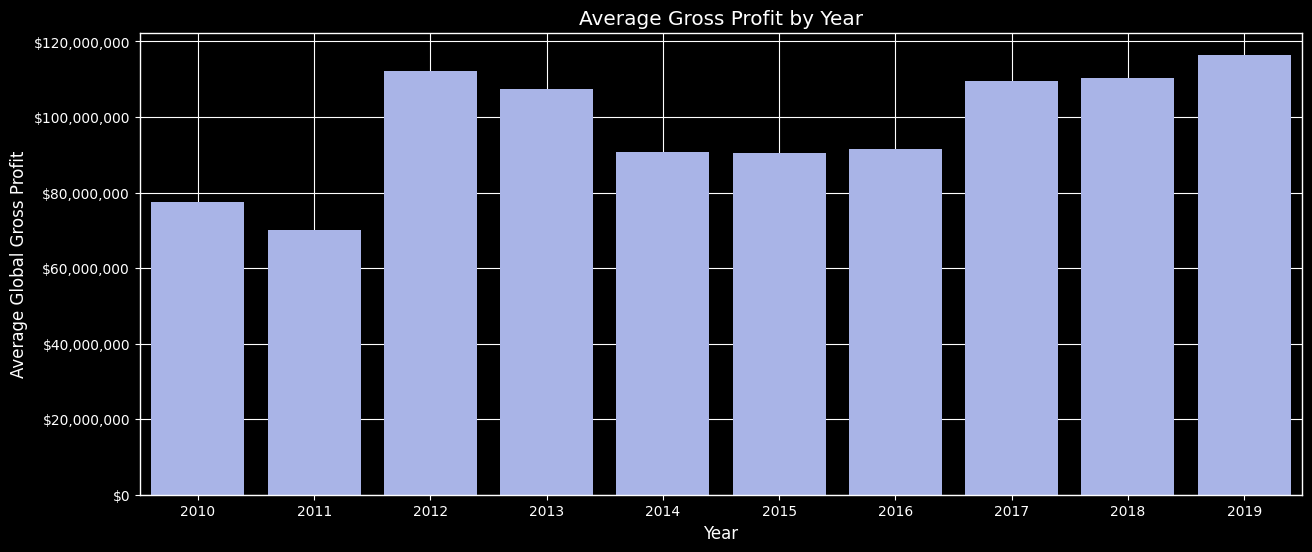

In [ ]:
# =============================================================================
# Visualizations: Yearly Trends and Runtime Analyses
# =============================================================================
# Average Gross Profit by Year
profit_by_year = df.groupby('Year')['Global_Gross_Profit'].mean()
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(profit_by_year.index, profit_by_year.values, color='#a9b4e7')

ax.set_xlabel('Year')
ax.set_ylabel('Average Global Gross Profit')
ax.set_title('Average Gross Profit by Year')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.set_xticks(profit_by_year.index)  # Explicitly set ticks for proper alignment


ax.set_xlim(profit_by_year.index.min() - 0.5, profit_by_year.index.max() + 0.5)

plt.savefig("./Images/Gross Profit Per Year.png", dpi=150)
plt.show()



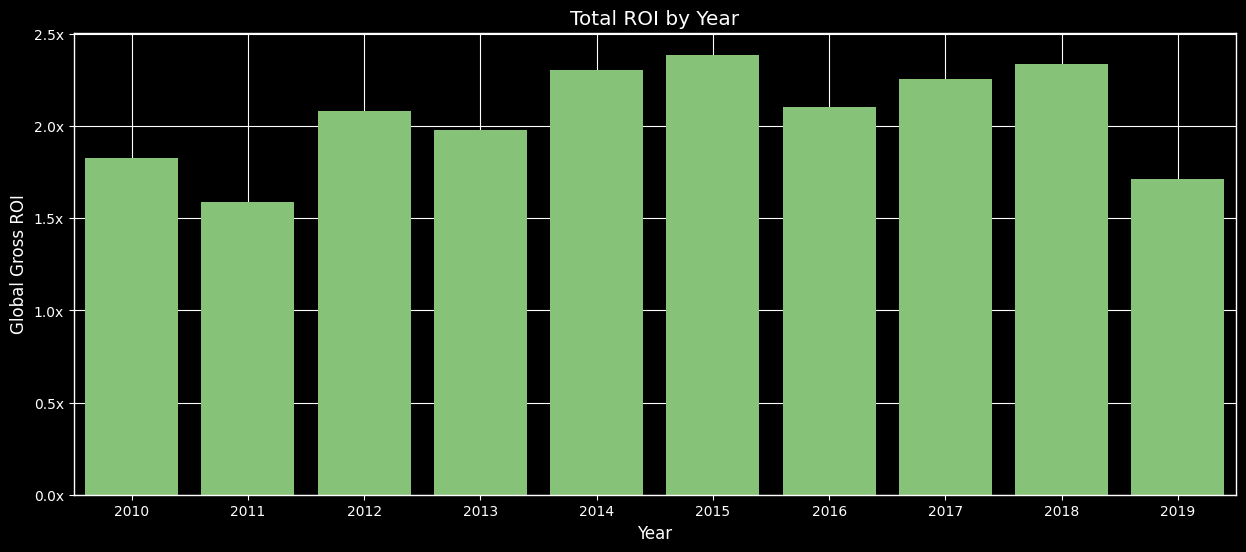

In [85]:
# Total ROI by Year
ROI_by_year = df[['Year', 'Global_Gross_Profit', 'Budget']].groupby('Year').sum()
ROI_by_year['ROI'] = ROI_by_year['Global_Gross_Profit'] / ROI_by_year['Budget']

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(ROI_by_year.index, ROI_by_year['ROI'], width=0.8, color='#86c277')

ax.set_xlabel('Year')
ax.set_xticks(ROI_by_year.index)
# Adjust x-axis limits to closely wrap around your data
ax.set_xlim(ROI_by_year.index.min() - 0.5, ROI_by_year.index.max() + 0.5)

ax.set_ylabel('Global Gross ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI by Year')

plt.show()


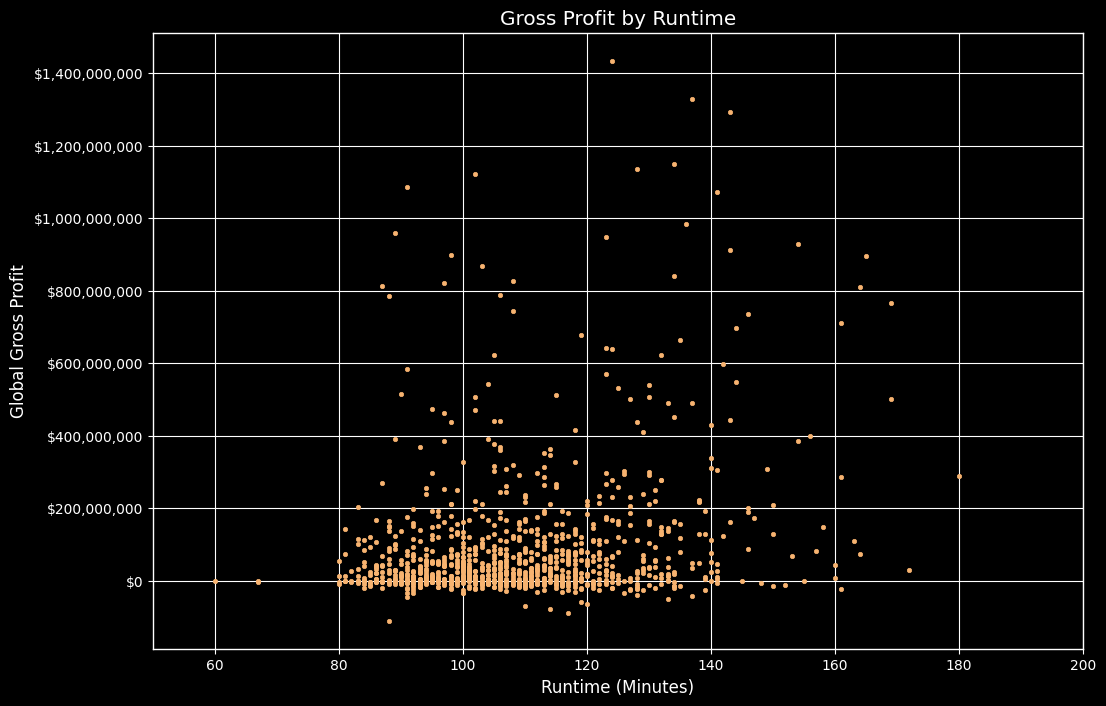

In [87]:
# Gross Profit vs. Runtime
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df['Runtime'], df['Global_Gross_Profit'], s=10, color='#f7b370')
ax.set_xlabel('Runtime (Minutes)')
ax.set_ylabel('Global Gross Profit')
ax.set_title('Gross Profit by Runtime')
ax.set_xlim(50, 200)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

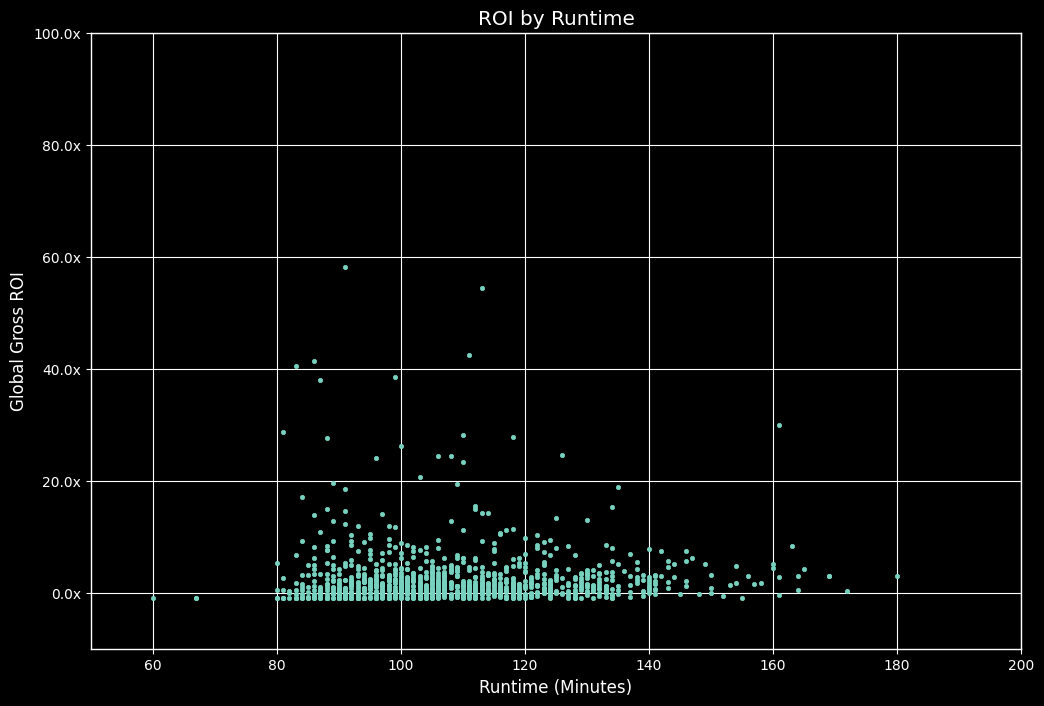

In [88]:
# ROI vs. Runtime
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df['Runtime'], df['Global_Gross_ROI'], s=10, color='#77d1bf')
ax.set_xlabel('Runtime (Minutes)')
ax.set_ylabel('Global Gross ROI')
ax.set_title('ROI by Runtime')
ax.set_xlim(50, 200)
ax.set_ylim(-10, 100)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))
plt.show()

*Analysis:*  
- Yearly trends reveal how average profit and ROI have evolved over time.
- Scatter plots help us explore if and how film runtime correlates with financial performance.


## 5. Detailed Segment Analyses

### 5.1. Genre Analysis

We perform genre-level analysis by splitting the Genres column into individual genres. This allows us to compute:
- Average and total global gross profit per genre.
- Distribution of gross profit among genres via a pie chart.
- Profit distribution for common genres through a boxplot.
- ROI for the most common genres.

These insights help the studio decide which film genres to prioritize.

In [92]:
# =============================================================================
# 6. Genre Analysis
# =============================================================================
# Explode the Genres column for detailed genre analysis
genres_exploded = df[['Title', 'Genres', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']].copy()
genres_exploded['Genres'] = genres_exploded['Genres'].fillna("").apply(lambda x: x.split(","))
genres_exploded = genres_exploded.explode('Genres')
genres_exploded = genres_exploded[genres_exploded['Genres'] != ""]
genres_exploded = genres_exploded[genres_exploded['Genres'] != "News"]
genres_exploded['Global_Gross_Profit'] = pd.to_numeric(genres_exploded['Global_Gross_Profit'], errors='coerce')
genres_exploded = genres_exploded.dropna(subset=['Global_Gross_Profit'])

genres_exploded.head(10)


,Title,Genres,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avengers: Age of Ultron,Action,1072413963,3,330600000
0,Avengers: Age of Ultron,Adventure,1072413963,3,330600000
0,Avengers: Age of Ultron,Sci-Fi,1072413963,3,330600000
1,The Dark Knight Rises,Action,809439099,3,275000000
1,The Dark Knight Rises,Thriller,809439099,3,275000000
2,Solo: A Star Wars Story,Action,118151347,0,275000000
2,Solo: A Star Wars Story,Adventure,118151347,0,275000000
2,Solo: A Star Wars Story,Fantasy,118151347,0,275000000
3,The Lone Ranger,Action,-14997885,-0,275000000
3,The Lone Ranger,Adventure,-14997885,-0,275000000


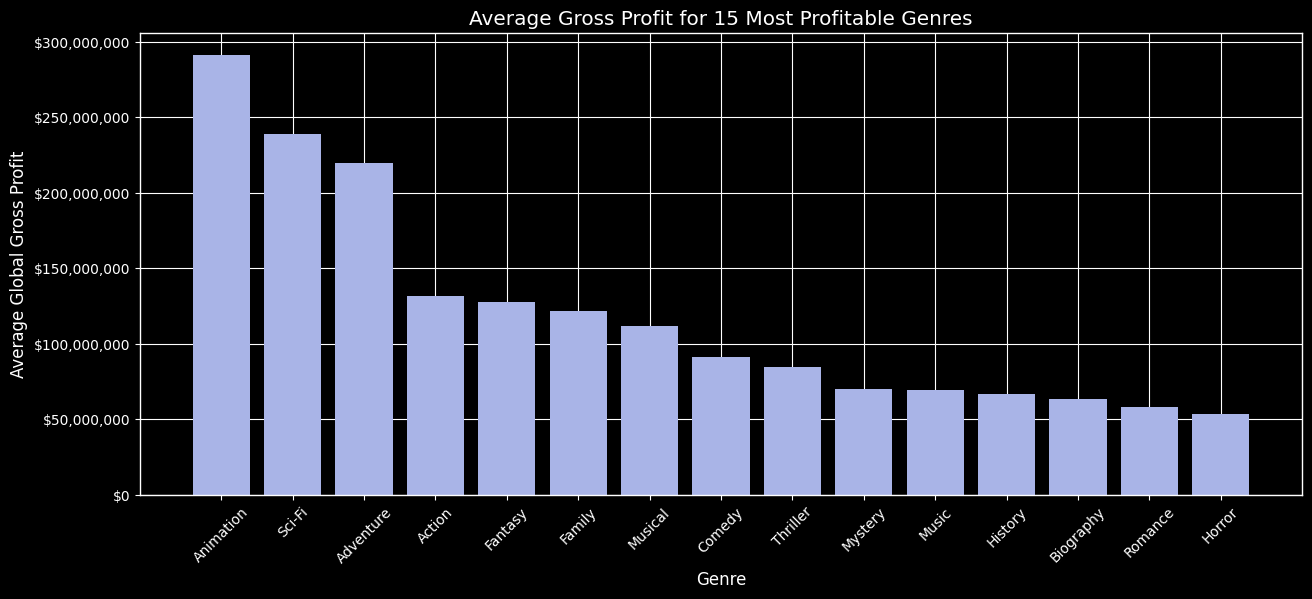

In [94]:
# Average Gross Profit by Genre (Top 15)
avg_profit_genre = genres_exploded.groupby('Genres')['Global_Gross_Profit'].mean().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(avg_profit_genre.index, avg_profit_genre.values, color='#a9b4e7')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Global Gross Profit')
ax.set_title('Average Gross Profit for 15 Most Profitable Genres')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

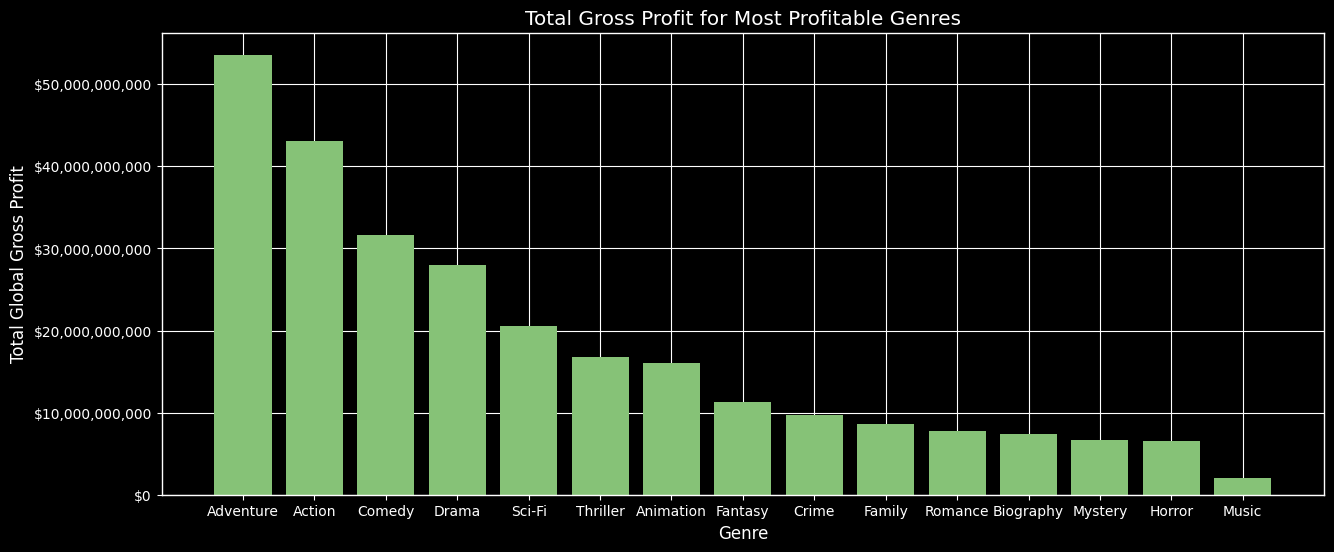

In [95]:
# Total Gross Profit by Genre (top 15)
total_profit_genre = genres_exploded.groupby('Genres')['Global_Gross_Profit'].sum().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(total_profit_genre.index, total_profit_genre.values, color='#86c277')
ax.set_xlabel('Genre')
ax.set_ylabel('Total Global Gross Profit')
ax.set_title('Total Gross Profit for Most Profitable Genres')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

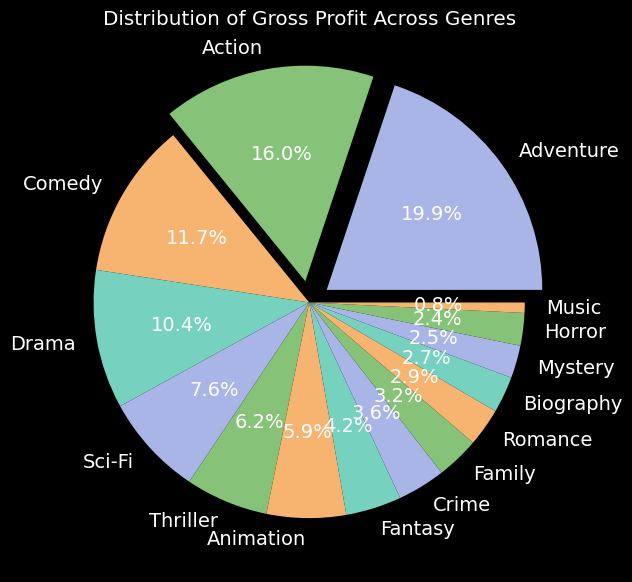

In [97]:
# Pie Chart: Distribution of Gross Profit Across Genres
fig, ax = plt.subplots(figsize=(7, 7))
explode_vals = (0.1, 0.1) + (0,)*13  
ax.pie(total_profit_genre, labels=total_profit_genre.index, autopct='%1.1f%%',
       colors=['#a9b4e7', '#86c277', '#f7b370', '#77d1bf']*4, explode=explode_vals, textprops={'fontsize': 14})
ax.set_title('Distribution of Gross Profit Across Genres')
plt.savefig("./Images/Pie Chart.png", dpi=150)
plt.show()

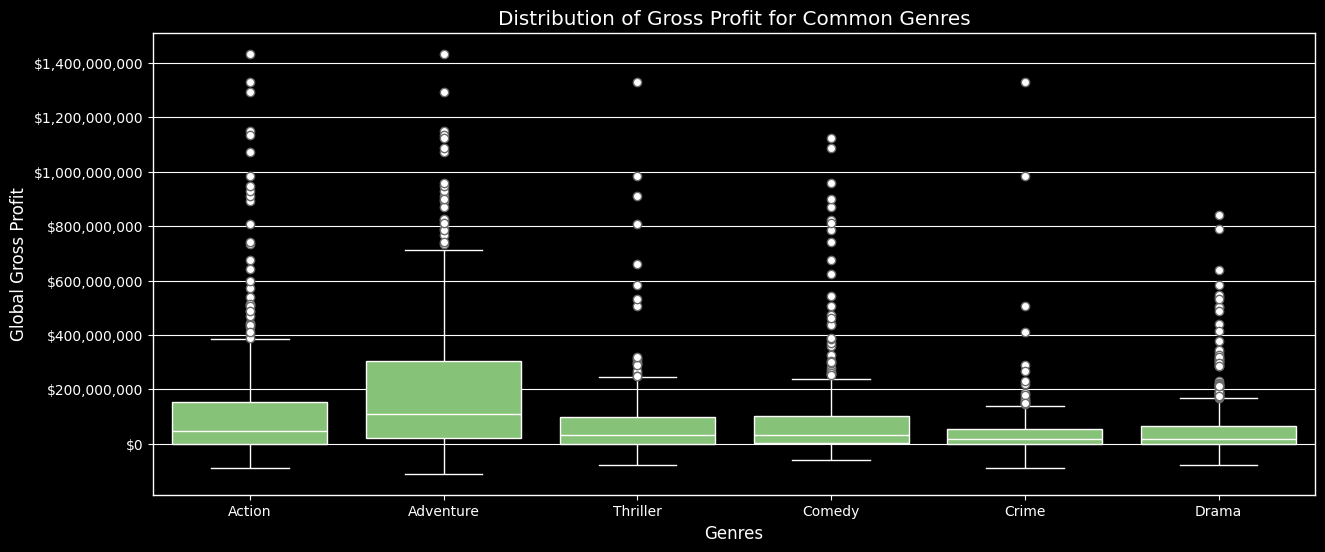

In [102]:
# Boxplot: Profit Distribution for Common Genres (occurring >150 times)
common_genres = genres_exploded['Genres'].value_counts()[lambda x: x > 150].index
genres_common = genres_exploded[genres_exploded['Genres'].isin(common_genres)]
fig, ax = plt.subplots(figsize=(15, 6))
box_props = {
    'boxprops': {'facecolor': '#86c277', 'edgecolor': 'white'},
    'medianprops': {'color': 'white'},
    'whiskerprops': {'color': 'white'},
    'capprops': {'color': 'white'},
    'flierprops': {'marker': 'o', 'markerfacecolor': 'white'}
}
sns.boxplot(x='Genres', y='Global_Gross_Profit', data=genres_common, **box_props)
ax.set_title('Distribution of Gross Profit for Common Genres')
ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.savefig("./Images/Distribution.png", dpi=150)
plt.show()

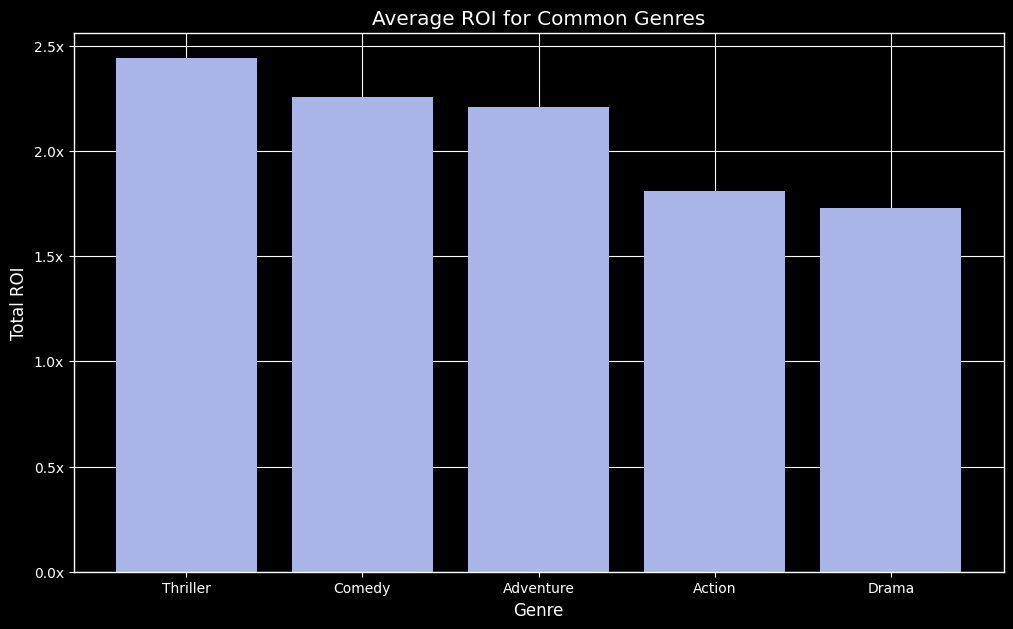

In [103]:
# ROI by Genre for Common Genres (Top 5)
roi_genre = genres_common.groupby('Genres').sum()
roi_genre['ROI'] = roi_genre['Global_Gross_Profit'] / roi_genre['Budget']
roi_genre = roi_genre.sort_values('ROI', ascending=False).head(5)
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(roi_genre.index, roi_genre['ROI'], color='#a9b4e7')
ax.set_xlabel('Genre')
ax.set_ylabel('Total ROI')
ax.set_title('Average ROI for Common Genres')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))
plt.savefig("./Images/ROI Genre.png", dpi=150)
plt.show()

In [106]:
# Additional Aggregated Stats for Selected Genres (e.g., Adventure, Action, Animation, Horror)
gp_info = genres_exploded.groupby('Genres').agg({'Global_Gross_Profit': ['min', 'max', 'median', 'mean', 'sum', 'std']})
print("\nAggregated Global Gross Profit stats for Adventure, Action, Animation, and Horror:")
print(gp_info.loc[['Adventure', 'Action', 'Animation', 'Horror']])




Aggregated Global Gross Profit stats for Adventure, Action, Animation, and Horror:
          Global_Gross_Profit                                             \
                          min        max    median      mean         sum   
Genres                                                                     
Adventure          -110450242 1433854864 110526487 219666949 53598735640   
Action              -90000000 1433854864  45421224 131633396 43044120368   
Animation          -110450242 1122469910 161900902 291285780 16020717897   
Horror              -79448583  662457969  29146087  53564889  6588481290   

                     
                std  
Genres               
Adventure 292403994  
Action    236183837  
Animation 316085434  
Horror     88247984  


In [107]:
ROI_info = genres_exploded.groupby('Genres').sum()
ROI_info = ROI_info['Global_Gross_Profit'] / ROI_info['Budget']
print("\nAggregated ROI for Adventure, Action, Animation, and Horror:")
print(ROI_info.loc[['Adventure', 'Action', 'Animation', 'Horror']])




Aggregated ROI for Adventure, Action, Animation, and Horror:
Genres
Adventure   2
Action      2
Animation   3
Horror      3
dtype: float64


In [108]:
budget_info = genres_exploded.groupby('Genres').agg({'Budget': ['mean', 'min', 'max', 'median', 'sum']})
print("\nBudget stats for Adventure, Action, Animation, and Horror:")
print(budget_info.loc[['Adventure', 'Action', 'Animation', 'Horror']])


Budget stats for Adventure, Action, Animation, and Horror:
            Budget                                       
              mean     min       max   median         sum
Genres                                                   
Adventure 99368033 1800000 330600000 90000000 24245800000
Action    72847401  300000 330600000 50000000 23821100000
Animation 95072727 5000000 260000000 80000000  5229000000
Horror    20092480   25000 178000000 10000000  2471375000


We see much greater greater range for Adventure and Action, further distinguishing them as higher risk genres. 

### 5.2. Director Analysis

We now analyze film performance by director to identify talent with strong track records. This includes:
- Total gross profit per director.
- Average ROI for directors with at least 5 films.

In [109]:
# =============================================================================
# Director Analysis
# =============================================================================
# Prepare director-level data by splitting and exploding the Directors column
directors_df = df[['Title', 'Directors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']].copy()
directors_df['Directors'] = directors_df['Directors'].fillna("").apply(lambda x: x.split(","))
directors_df = directors_df.explode('Directors')
directors_df = directors_df[directors_df['Directors'] != ""]


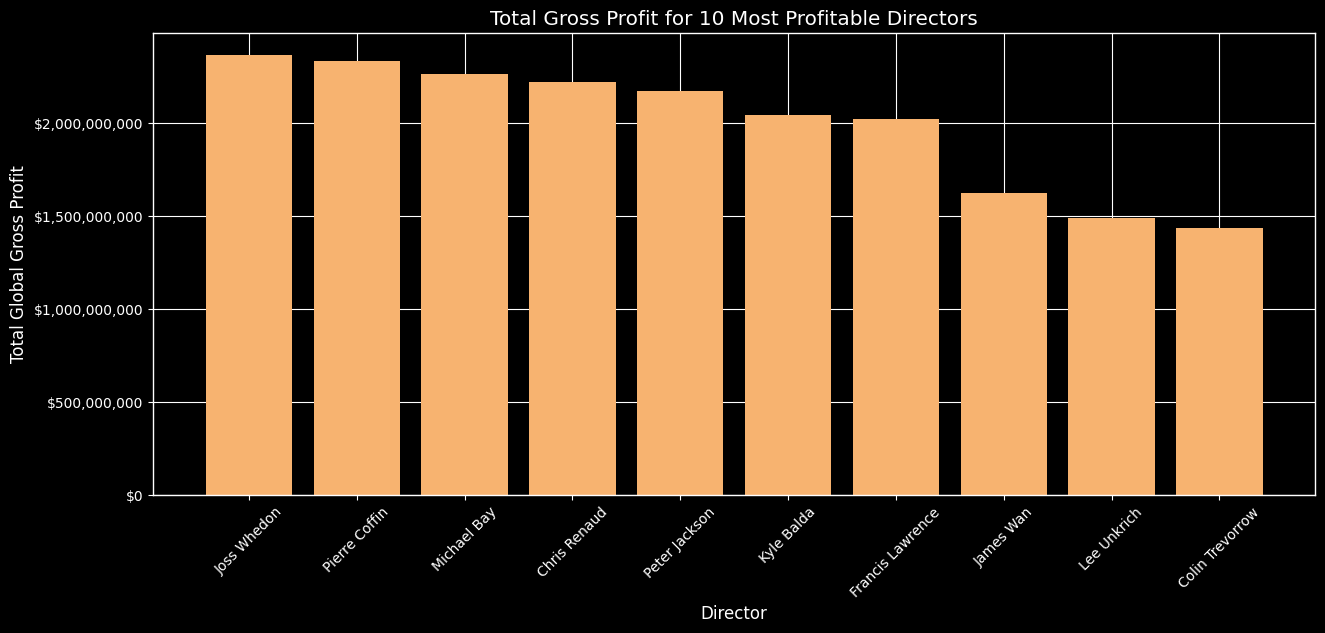

In [110]:
# Total Gross Profit by Director (Top 10)
total_profit_director = directors_df.groupby('Directors')['Global_Gross_Profit'].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(total_profit_director.index, total_profit_director.values, color='#f7b370')
ax.set_xlabel('Director')
ax.set_ylabel('Total Global Gross Profit')
ax.set_title('Total Gross Profit for 10 Most Profitable Directors')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

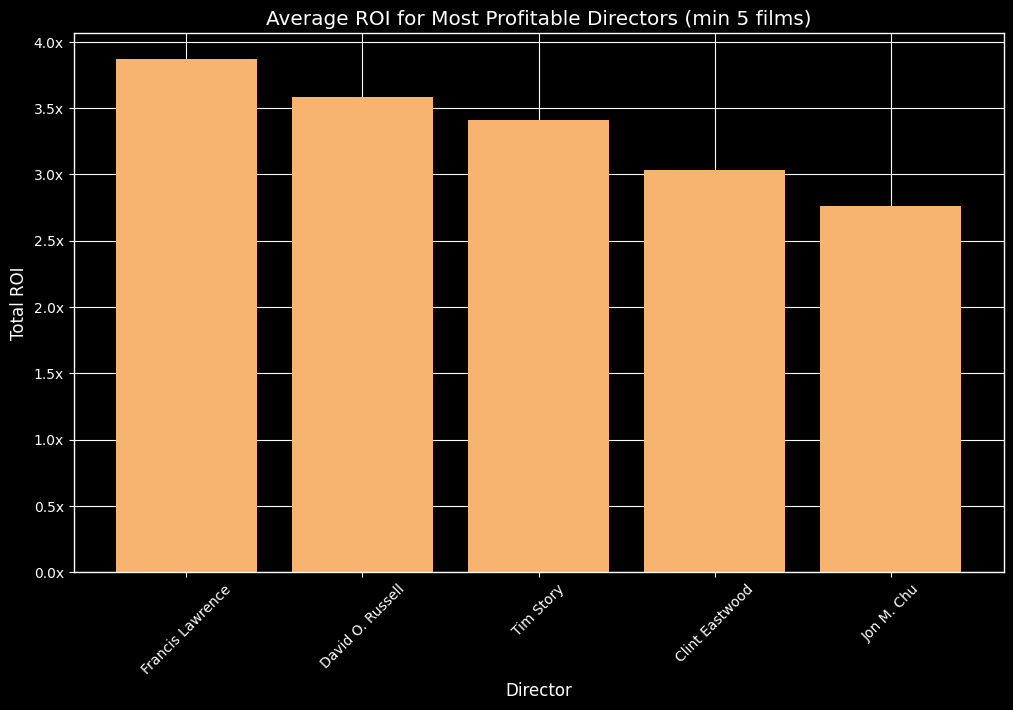

In [115]:
# Average ROI by Director (Directors with at least 5 films, Top 5)
director_counts = directors_df['Directors'].value_counts()
common_directors = director_counts[director_counts >= 5].index
directors_common = directors_df[directors_df['Directors'].isin(common_directors)]
roi_director = directors_common.groupby('Directors').sum()
roi_director['ROI'] = roi_director['Global_Gross_Profit'] / roi_director['Budget']
roi_director = roi_director.sort_values('ROI', ascending=False).head(5)
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(roi_director.index, roi_director['ROI'], color='#f7b370')
ax.set_xlabel('Director')
ax.set_ylabel('Total ROI')
ax.set_title('Average ROI for Most Profitable Directors (min 5 films)')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))
plt.savefig("./Images/roi of directors.png", dpi=150, bbox_inches="tight")
plt.show()

### Actor Analysis

We also evaluate actor performance by computing:
- Total gross profit by actor.
- Average ROI for actors involved in at least 5 films.


In [116]:
# =============================================================================
# Actor Analysis
# =============================================================================
# Prepare actor-level data by splitting and exploding the Actors column
actors_df = df[['Title', 'Actors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']].copy()
actors_df['Actors'] = actors_df['Actors'].fillna("").apply(lambda x: x.split(","))
actors_df = actors_df.explode('Actors')
actors_df = actors_df[actors_df['Actors'] != ""]

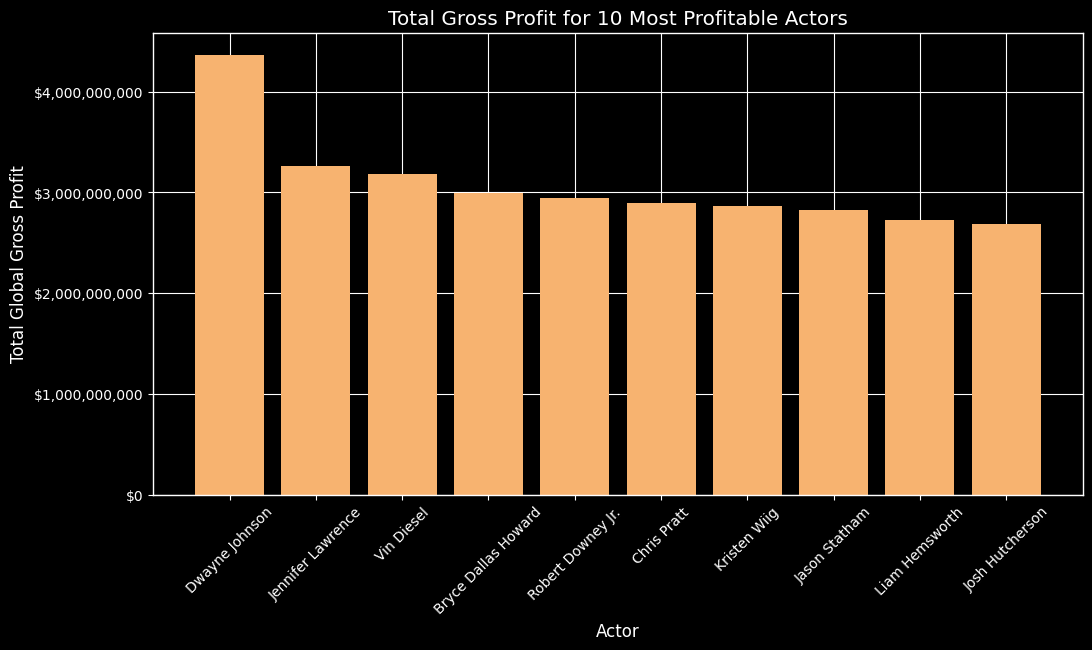

In [117]:
# Total Gross Profit by Actor (Top 10)
total_profit_actor = actors_df.groupby('Actors')['Global_Gross_Profit'].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(total_profit_actor.index, total_profit_actor.values, color='#f7b370')
ax.set_xlabel('Actor')
ax.set_ylabel('Total Global Gross Profit')
ax.set_title('Total Gross Profit for 10 Most Profitable Actors')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()


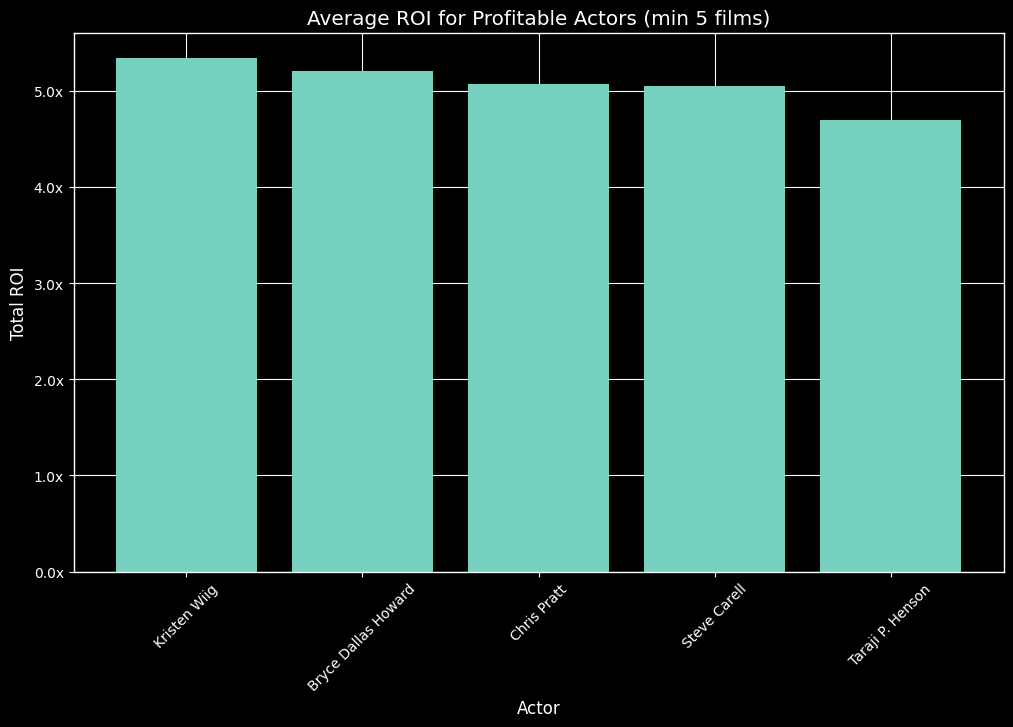

In [118]:
# Average ROI by Actor (Actors in at least 5 films, Top 5)
actor_counts = actors_df['Actors'].value_counts()
common_actors = actor_counts[actor_counts >= 5].index
actors_common = actors_df[actors_df['Actors'].isin(common_actors)]
roi_actor = actors_common.groupby('Actors').sum()
roi_actor['ROI'] = roi_actor['Global_Gross_Profit'] / roi_actor['Budget']
roi_actor = roi_actor.sort_values('ROI', ascending=False).head(5)
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(roi_actor.index, roi_actor['ROI'], color='#77d1bf')
ax.set_xlabel('Actor')
ax.set_ylabel('Total ROI')
ax.set_title('Average ROI for Profitable Actors (min 5 films)')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))
plt.savefig("./Images/roi of Actors.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Business Recommendations and Conclusion

Based on the analysis, we offer these recommendations for the new movie studio:

1. **Invest in High-ROI Films:**  
   Prioritize films with high Global Gross ROI as they indicate efficient budget usage, lowering financial risk.

2. **Target Profitable Genres:**  
   The genre analysis suggests that genres such as Adventure, Action, and Animation deliver strong profitability. Focusing on these genres may capture market demand.

3. **Collaborate with Proven Talent:**  
   Analysis of directors and actors highlights specific individuals associated with high grossing films. Strategic partnerships with such talent can enhance a film’s success.

### Conclusion

This notebook integrates detailed data preparation, comprehensive exploratory analysis, and segment-level evaluations to guide film production decisions. The reproducible code and clear visualizations ensure that the insights derived are actionable for the studio. Through this approach, the studio can:
- Identify films with strong revenue potential.
- Understand market trends over time and the influence of runtime.
- Focus on genres and talent with proven track records.